# 第13章 ニューラルネットワーク
## 数値計算ライブラリTheanoによるトレーニングの並列化

In [1]:
import theano
from theano import tensor as T

In [2]:
# initialize
x1 = T.scalar()
w1 = T.scalar()
w0 = T.scalar()
z1 = w1 * x1 + w0

# compile
net_input = theano.function(inputs=[w1, x1, w0], outputs=z1)

# execute
net_input(2.0, 1.0, 0.5)

array(2.5)

In [3]:
print(theano.config.floatX)

float64


In [4]:
theano.config.floatX = 'float32'

In [5]:
print(theano.config.device)

cpu


In [6]:
import numpy as np

# initialize
# if you are running Theano on 64 bit mode, 
# you need to use dmatrix instead of fmatrix
x = T.fmatrix(name='x')
x_sum = T.sum(x, axis=0)

# compile
calc_sum = theano.function(inputs=[x], outputs=x_sum)

# execute (Python list)
ary = [[1, 2, 3], [1, 2, 3]]
print('Column sum:', calc_sum(ary))

# execute (NumPy array)
ary = np.array([[1, 2, 3], [1, 2, 3]], dtype=theano.config.floatX)
print('Column sum:', calc_sum(ary))

Column sum: [ 2.  4.  6.]
Column sum: [ 2.  4.  6.]


In [7]:
# initialize
x = T.fmatrix(name='x')
w = theano.shared(np.asarray([[0.0, 0.0, 0.0]], 
                             dtype=theano.config.floatX))
z = x.dot(w.T)
update = [[w, w + 1.0]]

# compile
net_input = theano.function(inputs=[x], 
                            updates=update, 
                            outputs=z)

# execute
data = np.array([[1, 2, 3]], dtype=theano.config.floatX)
for i in range(5):
    print('z%d:' % i, net_input(data))

z0: [[ 0.]]
z1: [[ 6.]]
z2: [[ 12.]]
z3: [[ 18.]]
z4: [[ 24.]]


In [8]:
# initialize
data = np.array([[1, 2, 3]], 
                dtype=theano.config.floatX)
x = T.fmatrix(name='x')
w = theano.shared(np.asarray([[0.0, 0.0, 0.0]], 
                             dtype=theano.config.floatX))
z = x.dot(w.T)
update = [[w, w + 1.0]]

# compile
net_input = theano.function(inputs=[], 
                            updates=update, 
                            givens={x: data},
                            outputs=z)

# execute
for i in range(5):
    print('z:', net_input())

z: [[ 0.]]
z: [[ 6.]]
z: [[ 12.]]
z: [[ 18.]]
z: [[ 24.]]


In [9]:
import numpy as np
X_train = np.asarray([[0.0], [1.0], [2.0], [3.0], [4.0],
                      [5.0], [6.0], [7.0], [8.0], [9.0]], 
                     dtype=theano.config.floatX)

y_train = np.asarray([1.0, 1.3, 3.1, 2.0, 5.0, 
                      6.3, 6.6, 7.4, 8.0, 9.0], 
                     dtype=theano.config.floatX)

In [10]:
import theano
from theano import tensor as T
import numpy as np

def train_linreg(X_train, y_train, eta, epochs):

    costs = []
    # Initialize arrays
    eta0 = T.fscalar('eta0')
    y = T.fvector(name='y') 
    X = T.fmatrix(name='X')   
    w = theano.shared(np.zeros(
                      shape=(X_train.shape[1] + 1),
                      dtype=theano.config.floatX),
                      name='w')
    
    # calculate cost
    net_input = T.dot(X, w[1:]) + w[0]
    errors = y - net_input
    cost = T.sum(T.pow(errors, 2)) 

    # perform gradient update
    gradient = T.grad(cost, wrt=w)
    update = [(w, w - eta0 * gradient)]

    # compile model
    train = theano.function(inputs=[eta0],
                            outputs=cost,
                            updates=update,
                            givens={X: X_train,
                                    y: y_train})      
    
    for _ in range(epochs):
        costs.append(train(eta))
    
    return costs, w

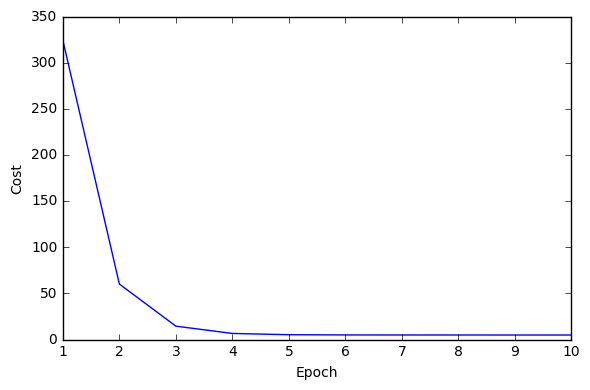

In [11]:
import matplotlib.pyplot as plt

costs, w = train_linreg(X_train, y_train, eta=0.001, epochs=10)
   
plt.plot(range(1, len(costs)+1), costs)

plt.tight_layout()
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.tight_layout()
# plt.savefig('./figures/cost_convergence.png', dpi=300)
plt.show()

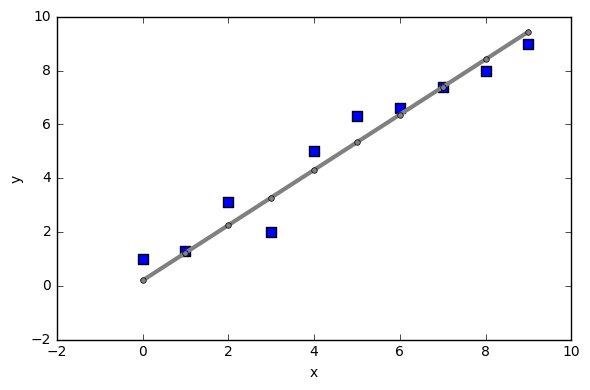

In [12]:
def predict_linreg(X, w):
    Xt = T.matrix(name='X')
    net_input = T.dot(Xt, w[1:]) + w[0]
    predict = theano.function(inputs=[Xt], givens={w: w}, outputs=net_input)
    return predict(X)

plt.scatter(X_train, y_train, marker='s', s=50)
plt.plot(range(X_train.shape[0]), 
         predict_linreg(X_train, w), 
         color='gray', 
         marker='o', 
         markersize=4, 
         linewidth=3)

plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
# plt.savefig('./figures/linreg.png', dpi=300)
plt.show()

In [13]:
# note that first element (X[0] = 1) to denote bias unit

X = np.array([[1, 1.4, 1.5]])
w = np.array([0.0, 0.2, 0.4])

def net_input(X, w):
    z = X.dot(w)
    return z

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(X, w):
    z = net_input(X, w)
    return logistic(z)

print('P(y=1|x) = %.3f' % logistic_activation(X, w)[0])

P(y=1|x) = 0.707


In [14]:
# W : array, shape = [n_output_units, n_hidden_units+1]
#          Weight matrix for hidden layer -> output layer.
# note that first column (W[:][0]) contains the bias units
W = np.array([[1.1, 1.2, 1.3, 0.5],
              [0.1, 0.2, 0.4, 0.1],
              [0.2, 0.5, 2.1, 1.9]])

# A : array, shape = [n_hidden+1, n_samples]
#          Activation of hidden layer.
# note that first element (A[0][0] = 1) is for the bias units

A = np.array([[1.0], 
              [0.1], 
              [0.3], 
              [0.7]])

# Z : array, shape = [n_output_units, n_samples]
#          Net input of output layer.

Z = W.dot(A) 
y_probas = logistic(Z)
print('Probabilities:\n', y_probas)

Probabilities:
 [[ 0.87653295]
 [ 0.57688526]
 [ 0.90114393]]


In [15]:
y_class = np.argmax(Z, axis=0)
print('predicted class label: %d' % y_class[0])

predicted class label: 2


In [16]:
def softmax(z): 
    return np.exp(z) / np.sum(np.exp(z))

def softmax_activation(X, w):
    z = net_input(X, w)
    return softmax(z)

In [17]:
y_probas = softmax(Z)
print('Probabilities:\n', y_probas)

Probabilities:
 [[ 0.40386493]
 [ 0.07756222]
 [ 0.51857284]]


In [18]:
y_probas.sum()

1.0

In [19]:
y_class = np.argmax(Z, axis=0)
y_class

array([2])

In [20]:
def tanh(z):
    e_p = np.exp(z) 
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)

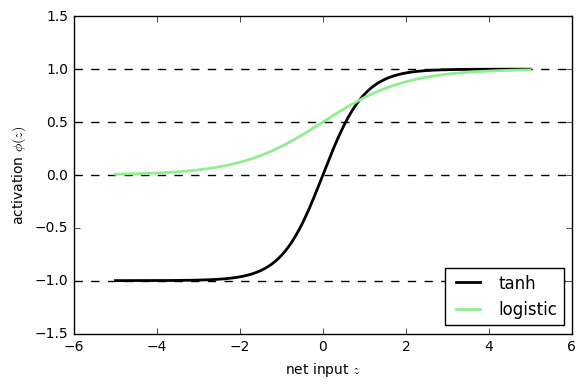

In [21]:
import matplotlib.pyplot as plt

z = np.arange(-5, 5, 0.005)
log_act = logistic(z)
tanh_act = tanh(z)

# alternatives:
# from scipy.special import expit
# log_act = expit(z)
# tanh_act = np.tanh(z)

plt.ylim([-1.5, 1.5])
plt.xlabel('net input $z$')
plt.ylabel('activation $\phi(z)$')
plt.axhline(1, color='black', linestyle='--')
plt.axhline(0.5, color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.axhline(-1, color='black', linestyle='--')

plt.plot(z, tanh_act, 
         linewidth=2, 
         color='black', 
         label='tanh')
plt.plot(z, log_act, 
         linewidth=2, 
         color='lightgreen', 
         label='logistic')

plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig('./figures/activation.png', dpi=300)
plt.show()

In [29]:
import os
import struct
import numpy as np
 
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
 
    return images, labels

In [31]:
X_train, y_train = load_mnist('mnist', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

Rows: 60000, columns: 784


In [32]:
X_test, y_test = load_mnist('mnist', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 10000, columns: 784


In [35]:
import theano 

theano.config.floatX = 'float32'
X_train = X_train.astype(theano.config.floatX)
X_test = X_test.astype(theano.config.floatX)

In [37]:
from keras.utils import np_utils

print('First 3 labels: ', y_train[:3])

y_train_ohe = np_utils.to_categorical(y_train) 
print('\nFirst 3 labels (one-hot):\n', y_train_ohe[:3])

Using TensorFlow backend.


First 3 labels:  [5 0 4]

First 3 labels (one-hot):
 [[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


In [38]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

np.random.seed(1) 

model = Sequential()
model.add(Dense(input_dim=X_train.shape[1], 
                output_dim=50, 
                init='uniform', 
                activation='tanh'))

model.add(Dense(input_dim=50, 
                output_dim=50, 
                init='uniform', 
                activation='tanh'))

model.add(Dense(input_dim=50, 
                output_dim=y_train_ohe.shape[1], 
                init='uniform', 
                activation='softmax'))

sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
model.compile(loss='categorical_crossentropy', optimizer=sgd)

model.fit(X_train, y_train_ohe, 
          nb_epoch=50, 
          batch_size=300, 
          verbose=1, 
          validation_split=0.1, 
          show_accuracy=True)

/Users/okusama27/work/pydata/books_code_of_python/src/python_machine_learning/env/lib/python3.5/site-packages/keras/models.py:635: UserWarning: The "show_accuracy" argument is deprecated, instead you should pass the "accuracy" metric to the model at compile time:
`model.compile(optimizer, loss, metrics=["accuracy"])`
  warnings.warn('The "show_accuracy" argument is deprecated, '


Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 1s - loss: 2.2523 - val_loss: 2.1651
Epoch 2/50
54000/54000 [==============================] - 0s - loss: 1.9790 - val_loss: 1.7033
Epoch 3/50
54000/54000 [==============================] - 0s - loss: 1.4529 - val_loss: 1.1918
Epoch 4/50
54000/54000 [==============================] - 0s - loss: 1.0776 - val_loss: 0.9087
Epoch 5/50
54000/54000 [==============================] - 0s - loss: 0.8497 - val_loss: 0.7073
Epoch 6/50
54000/54000 [==============================] - 0s - loss: 0.6951 - val_loss: 0.5810
Epoch 7/50
54000/54000 [==============================] - 0s - loss: 0.5895 - val_loss: 0.4876
Epoch 8/50
54000/54000 [==============================] - 0s - loss: 0.5190 - val_loss: 0.4423
Epoch 9/50
54000/54000 [==============================] - 0s - loss: 0.4720 - val_loss: 0.4042
Epoch 10/50
54000/54000 [==============================] - 0s - loss: 0.4408 - val_loss: 0.3859


In [39]:
y_train_pred = model.predict_classes(X_train, verbose=0)
print('First 3 predictions: ', y_train_pred[:3])

First 3 predictions:  [5 0 4]


In [40]:
train_acc = np.sum(y_train == y_train_pred, axis=0) / X_train.shape[0]
print('Training accuracy: %.2f%%' % (train_acc * 100))

Training accuracy: 94.04%


In [41]:
y_test_pred = model.predict_classes(X_test, verbose=0)
test_acc = np.sum(y_test == y_test_pred, axis=0) / X_test.shape[0]
print('Test accuracy: %.2f%%' % (test_acc * 100))

Test accuracy: 93.75%
